# Análise de sentimentos em textos

- Este minicurso terá como base os comentário da Amazon, Yelp e IMDb
- Cada dataset contém registros, sendo 1 para reviews Positivos e 0 para Negativos.

In [1]:
import nltk
import spacy

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

warnings.filterwarnings('ignore')
%matplotlib inline

## Análise exploratória dos dados

In [2]:
arquivos_dict = {'amazon': 'amazon_cells_labelled.txt',
                 'yelp': 'yelp_labelled.txt',
                 'imdb': 'imdb_labelled.txt'}

df_list = []

for fonte, arquivos in arquivos_dict.items():
    df = pd.read_csv(arquivos, names=['sentence', 'label'], sep='\t')
    df['fonte'] = fonte
    df_list.append(df)
    
df = pd.concat(df_list)
print('Formato do arquivo {}'.format(df.shape))

Formato do arquivo (19086, 3)


In [3]:
df.sample(10)

,sentence,label,fonte
5600,This bluetooth is perfect.,NaN,amazon
8925,duh.summary:pros:*lightweight*comfortable*got ...,NaN,amazon
113,This film has no redeeming features.,0.0,imdb
489,10 out of 10 stars.,1.0,imdb
4675,I bought this for my son who is always talking...,NaN,amazon
14247,Works only in USA.,NaN,amazon
5294,BE CAREFUL !!!,NaN,amazon
2305,I found this headset at a loves travel stop.,NaN,amazon
3924,I purchased three of these batteries and each ...,NaN,amazon
13343,Design needs improvement.,NaN,amazon


#### Verificando a quantidades de amostrar com valores nulos

In [4]:
df.isnull().sum()

sentence        0
label       16338
fonte           0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.sample(10)

,sentence,label,fonte
1939,"Our waiter was very attentive, friendly, and i...",1.0,yelp
2059,This is simply the BEST bluetooth headset for ...,1.0,amazon
1515,"I don't each much pasta, but I love the homema...",1.0,yelp
1108,Reception is terrible and full of static.,0.0,amazon
1313,Oh and I forgot to also mention the weird colo...,0.0,amazon
1845,The cow tongue and cheek tacos are amazing.,1.0,yelp
1179,This is a VERY average phone with bad battery ...,0.0,amazon
175,"- Really, really good rice, all the time.",1.0,yelp
545,Tom Wilkinson's character is a man who is not ...,1.0,imdb
1357,I would recommend purchasing the Jabra JX-10 s...,1.0,amazon


Mesmo verificando os dados nulos com a função **isnull()**, em alguns casos os datasets de textos apresentam campos em branco

In [6]:
brancos = []

for indice, senteca, label, fonte in df.itertuples():
    if(senteca.isspace()): # retorna um TRUE se houver apenas um caractere em branco
        brancos.append(i)
        
brancos

[]

# Vamos plotar um WordCloud com os reviews

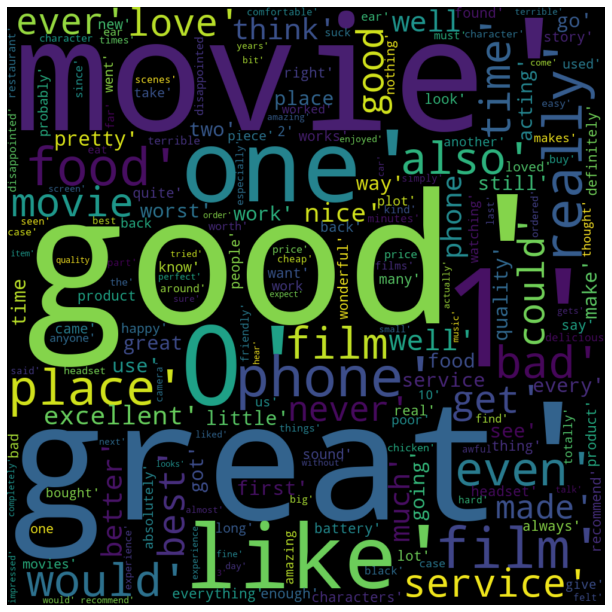

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwordsNltk = stopwords.words('english')

from wordcloud import WordCloud

words = []

for senteca in df.sentence:
    for palavra in senteca.lower().split():
        if(palavra not in stopwordsNltk):
            words.append(palavra)
            
words = str(words)

wordcloud = WordCloud(width=1000, height=1000, margin=0).generate(words)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)

## Antes de iniciarmos uma análise mais profunda e técnica, podemos procurar padrões “suspeitos” em nosso dataset.

- Será que existe diferença de tamanho (caracteres) do comentário entre os datasets?
- Podemos verificar alguma correlação tamanho do review x sentimento?
- A forma de escrita do comentário (exemplos: educado, rude, gírias, etc…) tem influência no sentimento **positivo** ou **negativo**?

Vamos descobrir através da vizualização dos dados

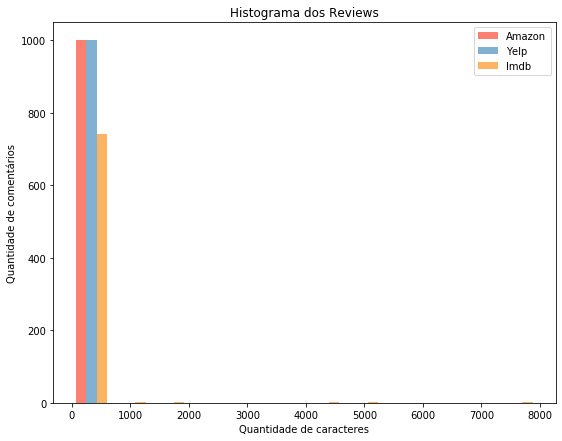

In [8]:
df['tamanho_texto'] = df['sentence'].apply(len)

x1 = list(df[df['fonte'] == 'amazon']['tamanho_texto'])
x2 = list(df[df['fonte'] == 'yelp']['tamanho_texto'])
x3 = list(df[df['fonte'] == 'imdb']['tamanho_texto'])

colors = ['#fb8072', '#80b1d3', '#fdb462']
names = ['Amazon', 'Yelp', 'Imdb']

plt.figure(figsize=(9,7))
plt.hist([x1, x2, x3], bins = int(180/15), normed=False, color = colors, label=names)

plt.xlabel('Quantidade de caracteres')
plt.ylabel('Quantidade de comentários')
plt.title('Histograma dos Reviews')
plt.legend();

Verificando rapidamente o histograma acima, não parece haver distinção entre os Datasets, apenas o Imdb apresenta alguns comentários mais longos que os demais. Mas será que isso influencia no sentimento do comentário: Positivo ou Negativo?

Vamos verificar...

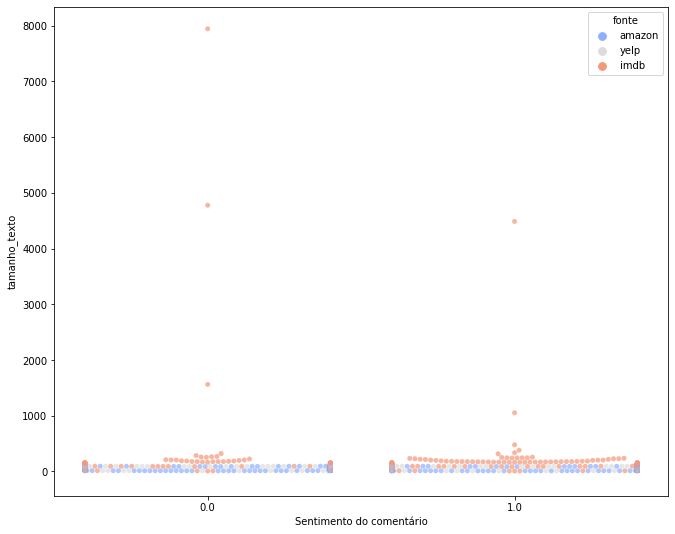

In [9]:
plt.figure(figsize=(11, 9))
sns.swarmplot(x='label', y='tamanho_texto', data=df, hue='fonte', alpha=0.7, palette='coolwarm')
plt.xlabel('Sentimento do comentário');

Conforme mostra nosso swarmplot, não há relação entre o tamanho do comentário com a probabilidade de ser Positivo ou Negativo.

# Vamos análisa gramaticamente os reviews

In [10]:
np.random.seed(100)

negativas = df[df['label'] == 0]
sample_neg = str(negativas.sentence.sample(2).values).split('\n')
positivas = df[df['label'] == 1]
sample_pos = str(positivas.sentence.sample(2).values).split('\n')
print(sample_neg)
print('\n')
print(sample_pos)

["['The real killer is the volume, and of course it breaking.'", " 'This may be the only bad film he ever made.  ']"]


["['Works well.' 'I had strawberry tea, which was good.']"]


In [11]:
nlp = spacy.load('en_core_web_sm')

# Review Negativa

In [14]:
doc = nlp(u"It was just too horrible.")
for token in doc:
    print(f'{token.text:{10}} {token.pos_:{10}} {token.tag_:{5}} {spacy.explain(token.tag)}')

It         PRON       PRP   None
was        AUX        VBD   None
just       ADV        RB    None
too        ADV        RB    None
horrible   ADJ        JJ    None
.          PUNCT      .     None


In [15]:
from spacy import displacy
displacy.render(doc, style='dep', jupyter=True, options={'distance': 128})

# Review Positiva

In [16]:
doc1 = nlp(u"Nevertheless yet another wonderful film from the great master\'s stable.")
displacy.render(doc1, style='dep', jupyter=True, options={'distance': 85})

# Vamos começar efetivamente a análise de sentimento com dataset da Amazon!

![amazon](amazon.png)

- A base de dados será dividida em 80 / 20, sendo respectivamente: Treino e Teste.
- Utilizado Stemming — Refere-se a um processo heurístico não muito refinado que corta as extremidades das palavras na esperança de atingir esse objetivo corretamente na maior parte do tempo, e geralmente inclui a remoção de afixos derivados.

In [17]:
amazon = df[df['fonte'] == 'amazon']
amazon = amazon[['sentence', 'label']]
print('Formato do Dataframe da Amazon {}'.format(amazon.shape))
amazon.head()

Formato do Dataframe da Amazon (1000, 2)


,sentence,label
1,So there is no way for me to plug it in here i...,0.0
2,"Good case, Excellent value.",1.0
5,Great for the jawbone.,1.0
10,Tied to charger for conversations lasting more...,0.0
11,The mic is great.,1.0


In [18]:
amazon['sentence'] = amazon['sentence'].str.replace('[^\w\s]','')

## Divisão da base de dados

In [19]:
from sklearn.model_selection import train_test_split
treino, teste = train_test_split(amazon, test_size=0.2)

In [23]:
print('Shape dos dados de Treino {}'.format(treino.shape))
treino.label.value_counts(normalize=True)

Shape dos dados de Treino (800, 2)


1.0    0.50375
0.0    0.49625
Name: label, dtype: float64

In [22]:
print('Shape dos dados de Teste {}'.format(teste.shape))
teste.label.value_counts(normalize=True)

Shape dos dados de Teste (200, 2)


0.0    0.515
1.0    0.485
Name: label, dtype: float64

# Aplicando Stemmer

In [24]:
treino = [tuple(x) for x in treino.values]

In [30]:
def aplica_stemmer(texto):
    stemmer = nltk.stem.SnowballStemmer('english')
    
    frases_sem_stemming = []
    for (palavras, sentimento) in texto:
        com_stemming = [str(stemmer.stem(p)) for p in palavras.lower().split() if p not in stopwordsNltk]
        frases_sem_stemming.append((com_stemming, sentimento))
    return frases_sem_stemming

In [31]:
frases_com_stem_treinamento = aplica_stemmer(treino)

In [32]:
pd.DataFrame(frases_com_stem_treinamento, columns=['frase', 'sentimento']).sample(10)

,frase,sentimento
162,"[real, improv]",0.0
520,"[return, 8, hour, later]",0.0
188,"[excel, product, satisfi, purchas]",1.0
425,"[super, charg, use, small, hybrid, palmtopcame...",1.0
715,"[piec, junk, broke, phone, 2, day]",0.0
706,"[portabl, work]",1.0
329,"[disappoint, batteri]",0.0
451,"[never, know, push, hard, enough, right, numbe...",0.0
392,"[research, develop, divis, obvious, know, theyr]",1.0
728,"[absolut, problem, headset, link, 8530, blackb...",1.0


In [33]:
teste = [tuple(x) for x in teste.values]
frases_com_stem_teste = aplica_stemmer(teste)

In [34]:
def busca_palavras(frases):
    todas_palavras = []
    for (palavras, sentimento) in frases:
        todas_palavras.extend(palavras)
    return todas_palavras

In [35]:
palavras_treinamento = busca_palavras(frases_com_stem_treinamento)
palavras_teste = busca_palavras(frases_com_stem_teste)

In [36]:
print('Quantidade de palavras na base de treinamento {}'.format(pd.DataFrame(palavras_treinamento).count()))

Quantidade de palavras na base de treinamento 0    4299
dtype: int64


# Listando palavras mais populares

In [39]:
def busca_frequencia(palavras):
    palavras = nltk.FreqDist(palavras)
    return palavras

In [40]:
frenquencia_treinamento = busca_frequencia(palavras_treinamento)
frenquencia_treinamento.most_common(10)

[('phone', 136),
 ('work', 88),
 ('great', 73),
 ('good', 65),
 ('use', 54),
 ('headset', 46),
 ('product', 45),
 ('qualiti', 43),
 ('batteri', 40),
 ('sound', 38)]

In [41]:
frenquencia_teste = busca_frequencia(palavras_teste)
frenquencia_teste.most_common(10)

[('phone', 37),
 ('work', 24),
 ('great', 24),
 ('use', 17),
 ('product', 11),
 ('well', 11),
 ('like', 10),
 ('good', 10),
 ('headset', 9),
 ('realli', 8)]

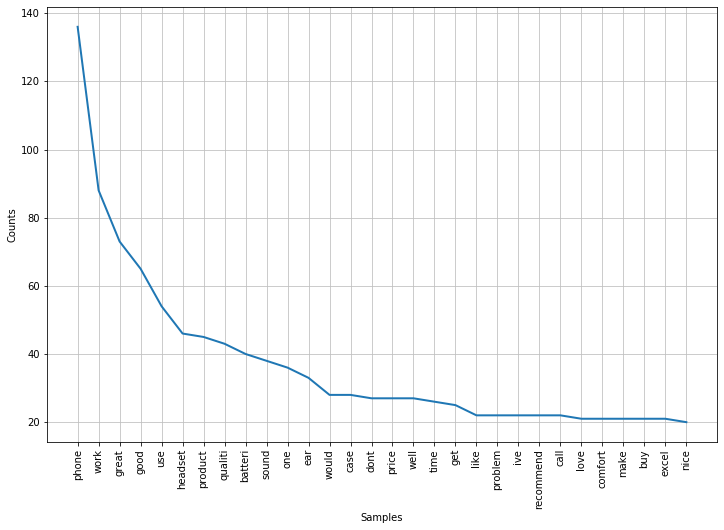

In [43]:
plt.figure(figsize=(12,8))
frenquencia_treinamento.plot(30, cumulative=False);

# Buscando palavras unicas

In [45]:
def busca_palavras_unicas(frequencia):
    freq = frequencia.keys()
    return freq

palavras_unicas_treinamento = busca_palavras_unicas(frenquencia_treinamento)
palavras_unicas_teste = busca_palavras_unicas(frenquencia_teste)

In [46]:
def extrator_palavras(documento):
    doc = set(documento)
    caracteristicas  = {}
    for palavras in palavras_unicas_treinamento:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [47]:
def extrator_palavras_teste(documento):
    doc = set(documento)
    caracteristicas  = {}
    for palavras in palavras_unicas_teste:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [48]:
base_completa_treinamento = nltk.classify.apply_features(extrator_palavras, frases_com_stem_treinamento)
base_completa_teste = nltk.classify.apply_features(extrator_palavras_teste, frases_com_stem_teste)

In [49]:
classificador = nltk.NaiveBayesClassifier.train(base_completa_treinamento)
print(classificador.labels())

[0.0, 1.0]


In [52]:
print('Acurácia: {}%'.format(nltk.classify.accuracy(classificador, base_completa_teste)))

Acurácia: 0.78%


# Como melhorar o modelo?

- Aumentar a base de dados para o treino e teste, com isso teríamos um modelo mais robusto.
- Testar outros algoritmos e hiperparâmetros.
- Incluir novas StopWords…

# Verificando os erros do modelo

In [53]:
erros = []
for (frase, classe) in base_completa_teste:
    resultado = classificador.classify(frase)
    if resultado != classe:
        erros.append((classe, resultado, frase))

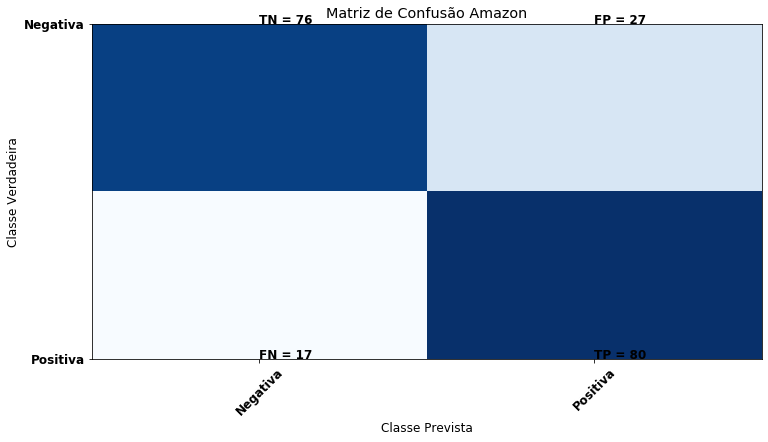

In [81]:
esperado = []
previsto = []
for (frase, classe) in base_completa_teste:
    resultado = classificador.classify(frase)
    previsto.append(resultado)
    esperado.append(classe)

    
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 12}    

plt.rc('font', **font)       
cm = confusion_matrix(esperado, previsto)
plt.figure(figsize=(12, 8))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
className = ['Negativa','Positiva']
plt.title('Matriz de Confusão Amazon')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
tick_marks = np.arange(len(className))
plt.xticks(tick_marks, className, rotation=45)
plt.yticks(tick_marks, className);
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j] + " = " + str(cm[i][j])))
plt.show();

# Probabilidade de cada classe

In [83]:
teste = 'i love the movie'
testeStemming = []
stemmer = nltk.stem.SnowballStemmer('english')
for (palavras_treinamento) in teste.split():
    comStem = [p for p in palavras_treinamento.split()]
    testeStemming.append(str(stemmer.stem(comStem[0])))
    
novo = extrator_palavras(testeStemming)
distribuicao = classificador.prob_classify(novo)

for classe in distribuicao.samples():
    print('%s: %f' % (classe, distribuicao.prob(classe)))
    if classe == 0:
        print('Probalidade de ser Negativa')
    else:
        print('Probalidade de ser Positiva')
        

0.0: 0.019410
Probalidade de ser Negativa
1.0: 0.980590
Probalidade de ser Positiva
